In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*Graph is not fully connected.*")
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1.*")

# ==== constants ====
n_neighbors = 200
min_dist = 1.0
state_id = 0

# folders: A01 ... A10
folders = [f"reverb_IHC3000_A{i:02d}" for i in range(1, 11)]

all_min_anechoic = []
all_min_reverb   = []
azimuths = None   # will fill from first folder

def compute_high_dim_distances(X_data, room_labels, azim_labels, room_target, metric='cosine'):
    """
    Computes distances between centroids in the original 512-D space.
    """
    # 1. Filter data for the specific room
    mask = (room_labels == room_target)
    X_subset = X_data[mask]
    azim_subset = azim_labels[mask]
    
    # 2. Compute Centroids in High-D (512 dimensions)
    # We group by azimuth and take the mean of the 512-D vectors
    df_high_d = pd.DataFrame(X_subset)
    df_high_d['azim'] = azim_subset
    
    # Group by azimuth and compute mean for all 512 feature columns
    centroids_df = df_high_d.groupby('azim').mean()
    
    # Sort by azimuth index to ensure matrix is ordered
    centroids_df = centroids_df.sort_index()
    unique_azims = centroids_df.index.values
    
    # 3. Compute Pairwise Distances
    centroids_array = centroids_df.values # Shape: (n_angles, 512)
    
    if metric == 'cosine':
        # Result is 0 to 2 (0=identical, 1=orthogonal, 2=opposite)
        dist_mat = np.round(cosine_distances(centroids_array), 2)
    else:
        dist_mat = np.round(euclidean_distances(centroids_array), 2)
        
    return pd.DataFrame(
        dist_mat,
        index=unique_azims,
        columns=unique_azims
    )

for folder in folders:
    print(f"Processing {folder} ...")
    
    # ==== Load & preprocess ====
    X_raw = np.load(f"{folder}/reverb_all_emb_penultimate_512.npy")
    azim_labels = np.squeeze(np.load("reverb_all_azim.npy"))
    azim_labels = ((azim_labels + 180) % 360) - 180  # wrap: 270..350 -> -90..-10

    room_labels = np.squeeze(np.load("reverb_all_index_room.npy"))
    room_labels[room_labels != 1] = 0  # 1 = anechoic; others combined as reverberant
    snr_labels = np.squeeze(np.load("reverb_all_snr.npy"))
    type_labels_raw = np.squeeze(np.load("reverb_all_label_word.npy"))

    # filter
    mask = np.isin(snr_labels, [12, 18, 24, np.inf]) & np.isin(room_labels, [0, 1, 2, 3, 4])
    indices = np.where(mask)[0]

    X = X_raw[indices]
    azim_sel = azim_labels[indices]
    room_sel = room_labels[indices]
    # type_labels = type_labels_raw[indices]  # not used here

    # angle -> [0,1] for HSV (just for grouping)
    c = (azim_sel - azim_sel.min()) / (azim_sel.max() - azim_sel.min())

    dist_anechoic = compute_high_dim_distances(X, room_sel, azim_sel, room_target=1, metric='cosine')
    dist_reverb = compute_high_dim_distances(X, room_sel, azim_sel, room_target=0, metric='cosine')

    # store azimuths once (sorted)
    if azimuths is None:
        azimuths = dist_anechoic.columns.values.astype(int)

    # remove diagonal (self-distance) by setting NaN, then take min per column
    dist_anechoic_no_diag = dist_anechoic.where(~np.eye(len(dist_anechoic), dtype=bool))
    dist_reverb_no_diag   = dist_reverb.where(~np.eye(len(dist_reverb), dtype=bool))

    min_ane = dist_anechoic_no_diag.min(axis=0).values  # shape (9,)
    min_rev = dist_reverb_no_diag.min(axis=0).values    # shape (9,)

    all_min_anechoic.append(min_ane)
    all_min_reverb.append(min_rev)

# stack to arrays: (10 folders, 9 azimuths)
all_min_anechoic = np.vstack(all_min_anechoic)
all_min_reverb   = np.vstack(all_min_reverb)

# ==== mean & SEM across folders ====
def mean_sem(arr, axis=0):
    mean = arr.mean(axis=axis)
    sem  = arr.std(axis=axis, ddof=1) / np.sqrt(arr.shape[axis])
    return mean, sem

mean_ane, sem_ane = mean_sem(all_min_anechoic, axis=0)
mean_rev, sem_rev = mean_sem(all_min_reverb, axis=0)

Processing reverb_IHC3000_A01 ...
Processing reverb_IHC3000_A02 ...
Processing reverb_IHC3000_A03 ...
Processing reverb_IHC3000_A04 ...
Processing reverb_IHC3000_A05 ...
Processing reverb_IHC3000_A06 ...
Processing reverb_IHC3000_A07 ...
Processing reverb_IHC3000_A08 ...
Processing reverb_IHC3000_A09 ...
Processing reverb_IHC3000_A10 ...


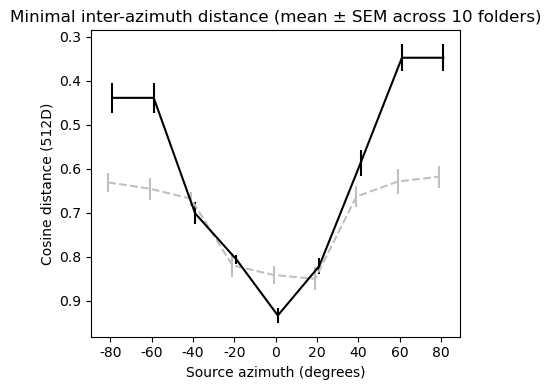

In [2]:
# ==== plot ====
x = np.arange(len(azimuths))

fig, ax = plt.subplots(figsize=(4.5, 4))

ax.errorbar(
    x - 0.05, mean_ane, yerr=sem_ane, color='silver',
    fmt='--', capsize=0, label='Anechoic'
)
ax.errorbar(
    x + 0.05, mean_rev, yerr=sem_rev, color='black',
    fmt='-', capsize=0, label='Reverberant'
)

ax.set_xticks(x)
ax.set_xticklabels(azimuths)
ax.set_xlabel("Source azimuth (degrees)")
ax.set_ylabel("Cosine distance (512D)")
ax.set_title("Minimal inter-azimuth distance (mean ± SEM across 10 folders)")
# ax.legend()
# ax.grid(alpha=0.3)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('reverb_IHC3000_A01-10_Cosine_legend_off.pdf', dpi=300, bbox_inches='tight') # _legend_off
plt.show()

In [3]:
all_min_anechoic

array([[0.72, 0.75, 0.72, 0.88, 0.92, 0.96, 0.75, 0.79, 0.75],
       [0.69, 0.69, 0.72, 0.93, 0.9 , 0.94, 0.7 , 0.63, 0.63],
       [0.69, 0.71, 0.69, 0.86, 0.94, 0.89, 0.68, 0.74, 0.68],
       [0.65, 0.69, 0.65, 0.8 , 0.81, 0.8 , 0.64, 0.58, 0.58],
       [0.58, 0.58, 0.64, 0.79, 0.73, 0.89, 0.68, 0.59, 0.59],
       [0.68, 0.73, 0.68, 0.76, 0.82, 0.75, 0.69, 0.68, 0.68],
       [0.54, 0.54, 0.64, 0.74, 0.78, 0.74, 0.51, 0.48, 0.48],
       [0.57, 0.57, 0.66, 0.89, 0.85, 0.87, 0.68, 0.56, 0.56],
       [0.64, 0.64, 0.72, 0.89, 0.85, 0.91, 0.74, 0.67, 0.67],
       [0.55, 0.55, 0.56, 0.65, 0.81, 0.75, 0.56, 0.57, 0.56]],
      dtype=float32)